---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [9]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

train = pd.read_csv('../readonly/train.csv', encoding='latin1') # File encoding is not utf-8
train = train.set_index('ticket_id')
train = train[['disposition','fine_amount','late_fee', 'compliance']].dropna()
X_1 = pd.get_dummies(train[['disposition','fine_amount','late_fee']]) # get_dummies creates binary
                                                # categories on 'disposition'
y_1 = train['compliance'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=0)

test = pd.read_csv('../readonly/test.csv', encoding='latin1') #Use for blight model test
test = test.set_index('ticket_id')
X_2 = pd.get_dummies(test[['disposition','fine_amount','late_fee']])
X_2 = X_2[X_1.columns] # The pd.get_dummies created more columns for 'dispostion' than are in X_1 data,
                        # this trims X_2 columns to X_1 columns, needed for MinMax scaling.
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_2_scaled = scaler.transform(X_2)

C:\Users\redex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


import pandas as pd
train = pd.read_csv('../readonly/train.csv', encoding='latin1')
#train.head()
train['compliance'].value_counts(dropna=False)


<IPython.core.display.Javascript object>


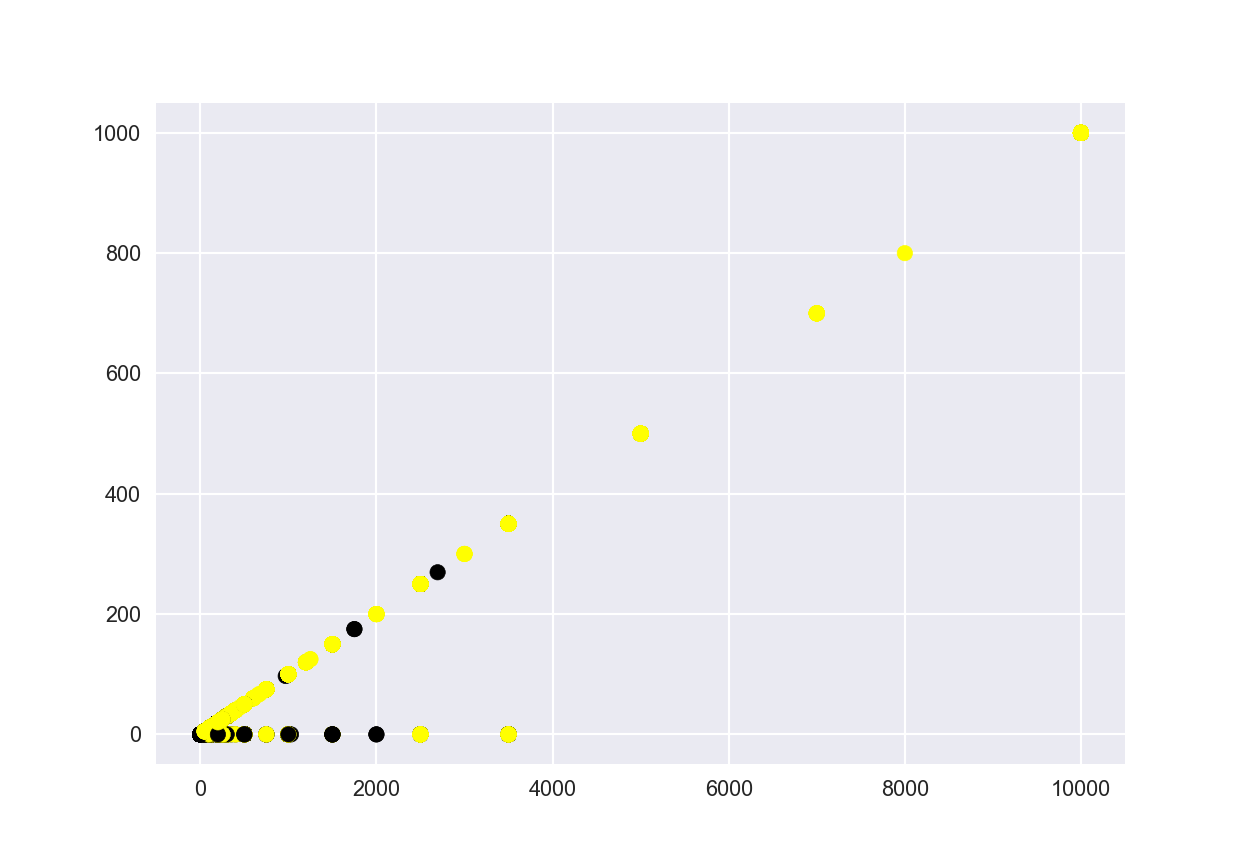

In [10]:
plt.scatter(X_1['fine_amount'], X_1['late_fee'], marker= 'o',
           c=y_1, s=50, cmap=cmap_bold);

### Gradient Boosting Decision Tree

In [170]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(random_state = 0).fit(X_train_scaled, y_train)

print('Blight data set (default: learning_rate=0.1, max_depth=3)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(gbdt.score(X_train_scaled, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(gbdt.score(X_test_scaled, y_test)))

Blight data set (default: learning_rate=0.1, max_depth=3)
Accuracy of GBDT classifier on training set: 0.94
Accuracy of GBDT classifier on test set: 0.94



In [162]:
clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 4, random_state = 0)
gbdt = clf.fit(X_train_scaled, y_train)

print('Blight data set(learning_rate=0.01, max_depth=4)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(gbdt.score(X_train_scaled, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(gbdt.score(X_test_scaled, y_test)))

Blight data set(learning_rate=0.01, max_depth=4)
Accuracy of GBDT classifier on training set: 0.94
Accuracy of GBDT classifier on test set: 0.94



<IPython.core.display.Javascript object>


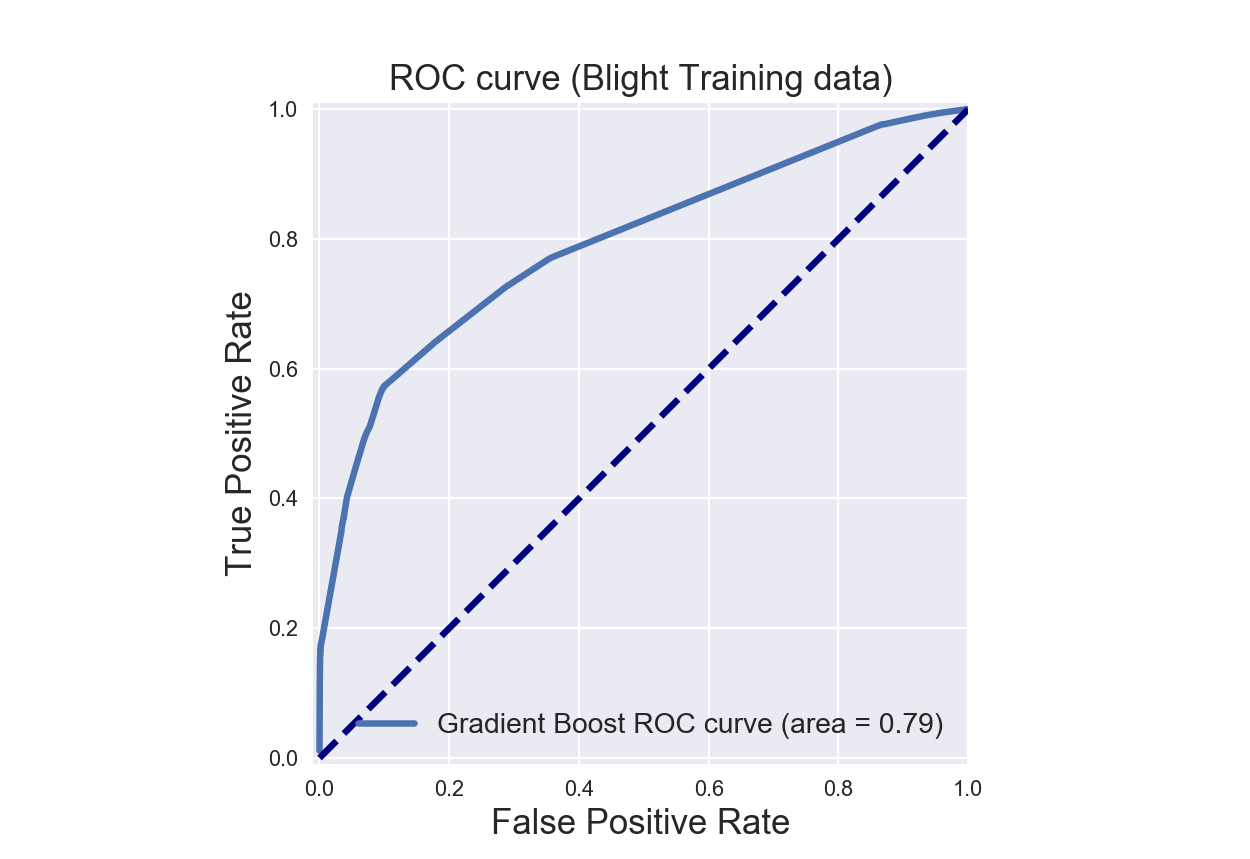

C:\Users\redex\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [171]:
from sklearn.metrics import roc_curve, auc

y_score_gb = gbdt.decision_function(X_test_scaled)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_gb, tpr_gb, lw=3, label='Gradient Boost ROC curve (area = {:0.2f})'.format(roc_auc_gb))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (Blight Training data)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


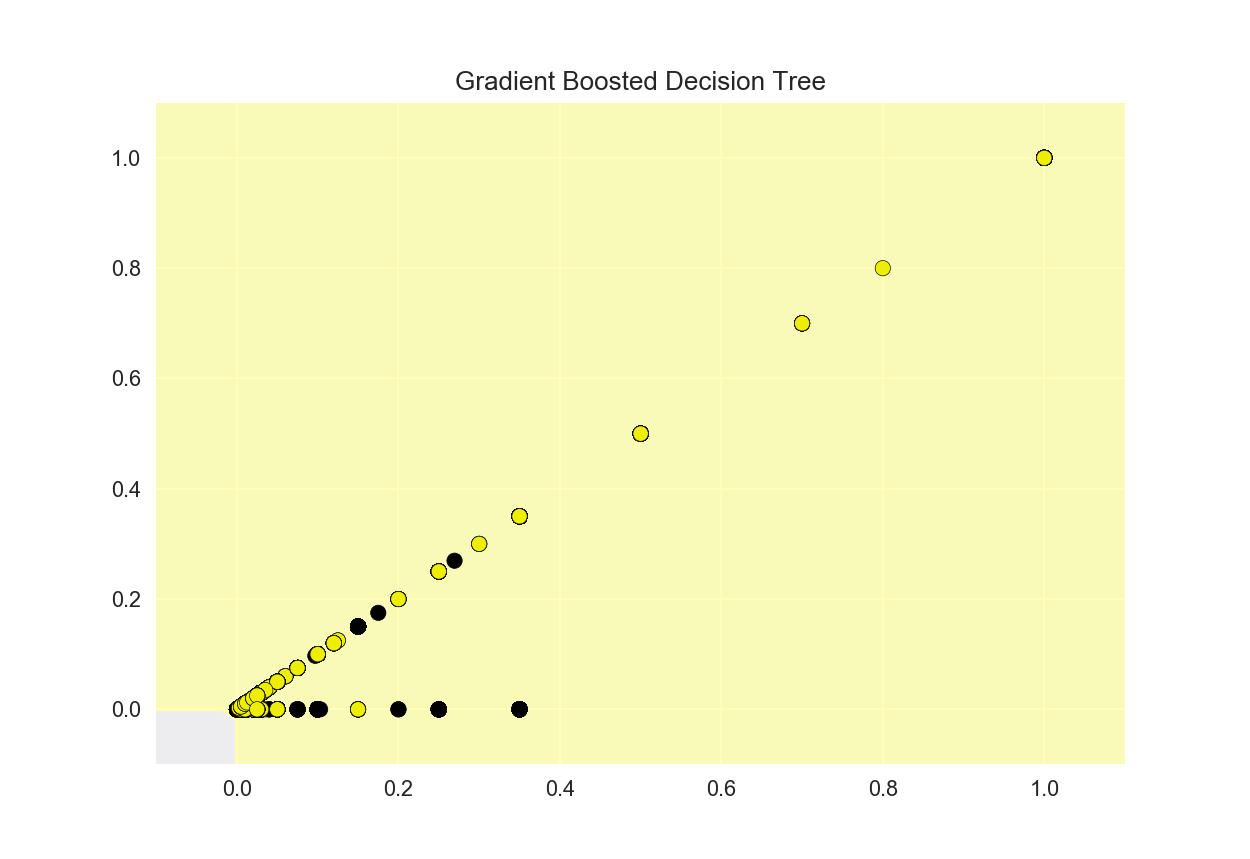

In [165]:
from adspy_shared_utilities import plot_class_regions_for_classifier

gbdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 4, random_state = 0).fit(X_train_scaled[:,0:2], y_train)
plot_class_regions_for_classifier(gbdt, X_train_scaled[:,0:2], y_train, None, None,
                                 'Gradient Boosted Decision Tree')

Prediction probability for Blight Test set

y_proba_gbdt = gbdt.predict_proba(X_2_scaled)
y_proba_series = pd.Series(data=y_proba_gbdt[:,1], index=X_2.index, name='compliance')
#y_proba_series.head()

### Linear Support Vector Classifier

In [168]:
from sklearn.svm import SVC
from adspy_shared_utilities import plot_class_regions_for_classifier

# The default SVC kernel is radial basis function (RBF)
clf = SVC(gamma=.01).fit(X_train_scaled, y_train)
#plot_class_regions_for_classifier(clf, X_train_scaled[:,0:2], y_train, None, None,
                                 #'Support Vector Classifier: RBF kernel')

# Compare decision boundries with polynomial kernel, degree = 3
#clf = SVC(kernel = 'poly', degree = 3).fit(X_train_scaled[:,0:2], y_train)
#plot_class_regions_for_classifier(clf, X_train_scaled[:,0:2], y_train, None, None,
                                 #'Support Vector Classifier: Polynomial kernel, degree = 3')

print('Blight data set ()')
print('Accuracy of SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of SVC classifier on test set: {:.2f}\n'
     .format(clf.score(X_test_scaled, y_test)))

Blight data set ()
Accuracy of SVC classifier on training set: 0.93
Accuracy of SVC classifier on test set: 0.93



<IPython.core.display.Javascript object>


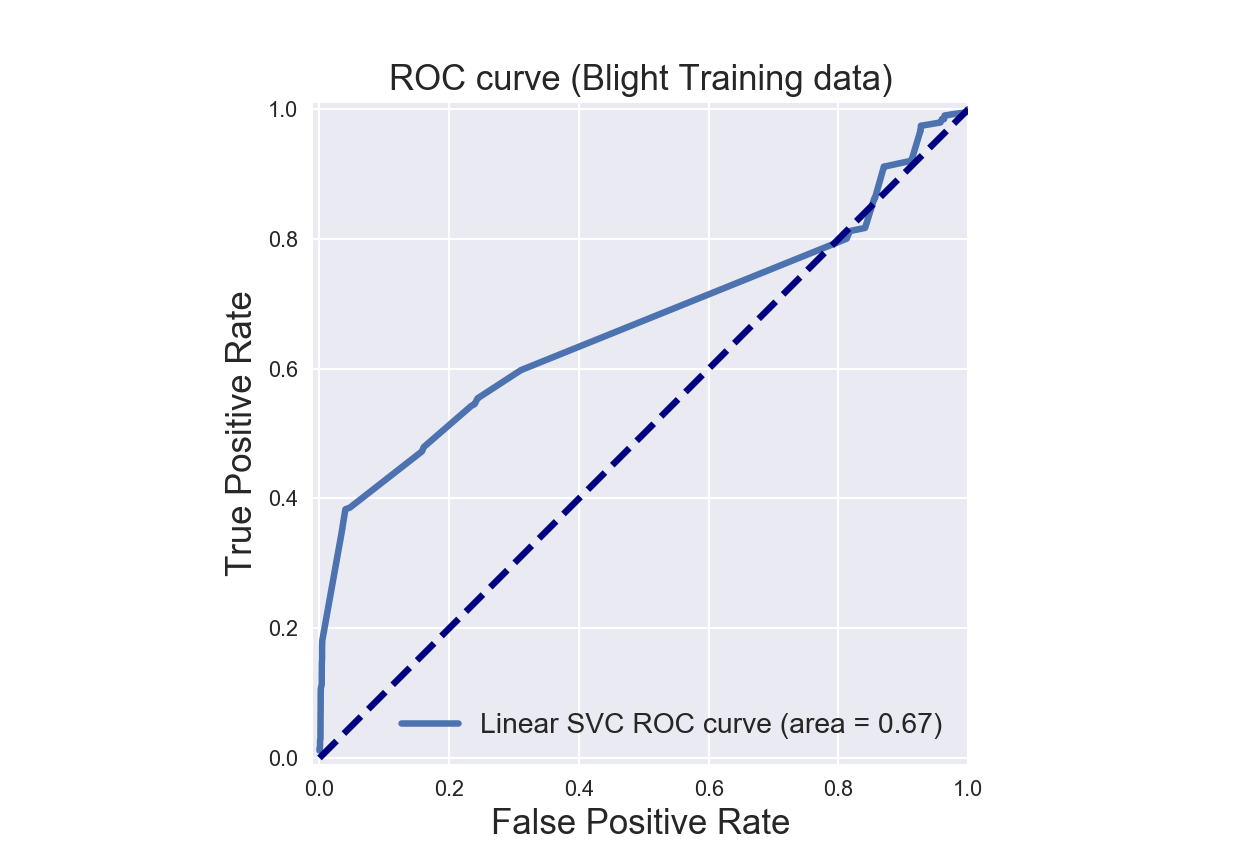

C:\Users\redex\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [169]:
from sklearn.metrics import roc_curve, auc

y_score_gb = clf.decision_function(X_test_scaled)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_gb, tpr_gb, lw=3, label='Linear SVC ROC curve (area = {:0.2f})'.format(roc_auc_gb))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (Blight Training data)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [173]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def blight_model():
    train = pd.read_csv('../readonly/train.csv', encoding='latin1') # File encoding is not utf-8
    train = train.set_index('ticket_id')
    train = train[['disposition','fine_amount','late_fee', 'compliance']].dropna()
    X_1 = pd.get_dummies(train[['disposition','fine_amount','late_fee']]) # get_dummies creates binary
                                                # categories on 'disposition'
    y_1 = train['compliance'].astype(int)
    
    test = pd.read_csv('../readonly/test.csv', encoding='latin1') #Use for blight model test
    test = test.set_index('ticket_id')    
    X_2 = pd.get_dummies(test[['disposition','fine_amount','late_fee']])
    X_2 = X_2[X_1.columns]

    X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=0)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_2_scaled = scaler.transform(X_2)
    
    clf = GradientBoostingClassifier(random_state = 0) # Default settings
    gbdt = clf.fit(X_train_scaled, y_train)
    y_proba_gbdt = gbdt.predict_proba(X_2_scaled)
    
    return pd.Series(data=y_proba_gbdt[:,1], index=X_2.index, name='compliance')

blight_model()

C:\Users\redex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2909: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


ticket_id
284932    0.049524
285362    0.014455
285361    0.060188
285338    0.049524
285346    0.060188
285345    0.049524
285347    0.051972
285342    0.913863
285530    0.014455
284989    0.019861
285344    0.051972
285343    0.014455
285340    0.014455
285341    0.051972
285349    0.060188
285348    0.049524
284991    0.019861
285532    0.019861
285406    0.019861
285001    0.019861
285006    0.014455
285405    0.014455
285337    0.019861
285496    0.051972
285497    0.049524
285378    0.014455
285589    0.019861
285585    0.049524
285501    0.060188
285581    0.014455
            ...   
376367    0.022175
376366    0.030521
376362    0.180023
376363    0.188035
376365    0.022175
376364    0.030521
376228    0.030521
376265    0.030521
376286    0.314105
376320    0.030521
376314    0.030521
376327    0.314105
376385    0.314105
376435    0.886217
376370    0.913863
376434    0.051972
376459    0.060188
376478    0.008302
376473    0.030521
376484    0.018103
376482    0.019861
37